# 11-1. 들어가며

### OCR = Text detection + Text recognition
---
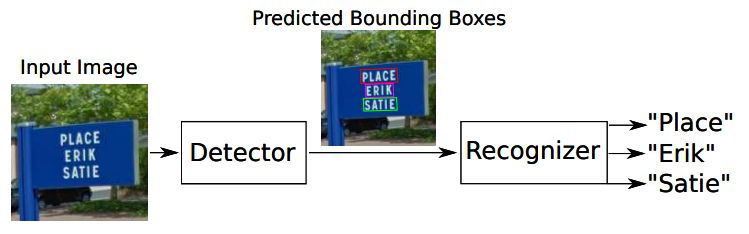

이번에는 딥러닝 기반의 OCR이 어떻게 이뤄지는지 알아보는 시간을 갖도록 하겠습니다. 위 그림에서 보는 것처럼, 이미지 속의 문자를 읽는 OCR은 크게 문자의 영역을 `검출`하는 `Text detection`과 검출된 영역의 문자를 `인식`하는 `Text recognition`으로 구분할 수 있습니다. 이 두 과정을 거쳐 이미지 속 문자를 읽게 되죠.

`Text detection`은 그동안 우리가 다루어 왔던 일반적인 Object detection 태스크를 문자 찾아내기로 확장한 버전이라고 생각할 수도 있겠습니다. 그러나 Text detection은 단순히 Object detection 기법뿐 아니라 Segmentation 기법도 동원되며, 문자가 가지는 독특한 특성까지 고려한 형태로 지속적으로 발전해 왔습니다.

`Text recognition`은 검출된 영역의 문자가 무엇인지를 인식해 내는 과정입니다. 아마도 MNIST처럼 이미지 안에 담겨 있는 문자를 구분해 내는 작업을 떠올리시겠죠? 하지만 Text detection을 통해 검출된 문자 영역 속에는 MNIST 데이터처럼 문자 단위로 잘 분리된 텍스트 이미지만 담겨 있는 것이 아닙니다. 이를 위해 OCR 분야에서 사용하는 독특한 모델 구조에 대해 다루게 될 것입니다.

그럼 그동안 우리가 열심히 공부해 왔던 Classification, Detection, Segmentation 등의 기법들이 어떻게 결합되어 OCR이라는 실용적인 애플리케이션으로 완성되어 가는지 살펴볼까요?

### 실습목표
---
- Deep learning 기반의 OCR을 이해합니다.
- Text를 Detection하기 위한 딥러닝 기법을 배웁니다.
- Text를 Recognize하기 위한 딥러닝 기법을 배웁니다.

# 11-2. Before Deep Learning

OCR(Optical Character Recognition)이라는 용어를 모를지라도 이미지 속에서 글자를 인식해내는 기술 자체에 대해는 그리 낯설게 느껴지지 않을 것입니다. 자동차 번호판 자동인식, 신용카드 광학 인식 등 이미 우리 생활 속에 OCR 기술이 자연스럽게 녹아들어 온 사례를 어렵지 않게 찾아낼 수 있습니다.

OCR의 역사는 딥러닝이 대중화되기 시작한 2010년대 초반으로부터 80년 이상이나 거슬러 올라간다고 합니다. 1928년 오스트리아의 Gustav Tauschek가 포토 센서를 활용한 패턴 매칭을 통해 제작한 "Reading Machine"을 제작했고 1931년 이스라엘의 Emanuel Goldberg가 "Statistical machine"의 특허를 내었는데, 이들이 최초의 OCR 장치로 여겨지고 있습니다.

상용화된 OCR은 1980년대부터 본격적으로 등장하였습니다. OCR의 역사에 대한 보다 자세한 정보는 [여기](https://en.wikipedia.org/wiki/Timeline_of_optical_character_recognition)를 참고해 봅시다.

그렇다면 딥러닝이 OCR에 활용되기 전에는 어떤 방식으로 이미지 속 문자를 찾아냈을까요? 아래 링크의 논문을 통해 그러한 예시를 살펴봅시다.

- [From Videos to URLs: A Multi-Browser Guide To Extract User’s Behavior with Optical Character Recognition](https://arxiv.org/pdf/1811.06193.pdf)

위 논문은 브라우저에서 동작하는 OCR을 이용하여 웹에서 유저의 행동을 관찰하는 방법을 제안합니다. 온라인 마케팅, 광고 등에도 OCR 기술을 활용할 수 있다는 내용입니다. 이 논문에서 제안하는 솔루션 구성도는 아래와 같습니다.

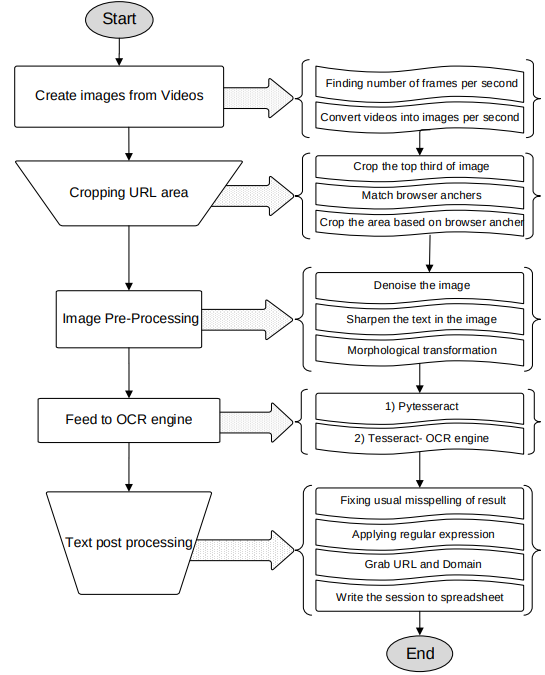

위 그림에서 OCR 엔진으로 Tesseract OCR을 사용하려고 하는 것을 확인할 수 있습니다. Tesseract OCR은 1985년 휴렛 패커드 사에서 개발이 시작되어 2005년에는 오픈소스로 출시되었고, 2006년부터는 구글의 후원을 받는 오픈소스 OCR 엔진입니다. (최근에는 Tesseract ocr에도 LSTM을 적용하는 등 딥러닝 베이스 아키텍처로 발전하고 있습니다! 자세한 내용은 [Tesseract ocr github](https://github.com/tesseract-ocr/tesseract)을 참고하세요!)

위 그림은 크게 5단계로 나뉘어 있는데, 위 3단계는 입력 이미지 추출과 전처리, 4번째 단계는 OCR 처리, 마지막 5번째 단계는 OCR의 출력 텍스트의 후처리로 구성됩니다. 여기서 Tesseract OCR을 통한 4단계의 과정을 아래 그림과 같이 정리하였습니다.

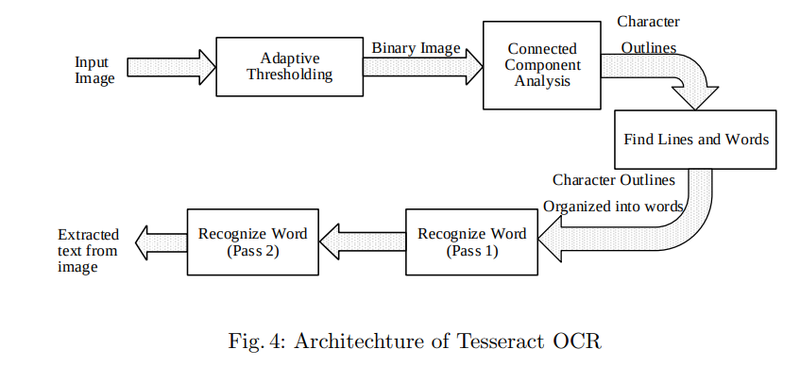

먼저 `Adaptive Thresholding` 단계에서 입력 영상의 이진화를 통해 흑백으로 변환합니다. 이후 `Connected Component Analysis` 단계에서 문자 영역을 검출한 후 `Find Lines and Words`에서 라인 또는 단어 단위를 추출합니다. 이후 `Recognize Word` 단계에서 단어(Word) 단위 이미지를 Text로 변환하기 위해 문자를 하나씩 인식하고 다시 결합하는 과정을 거칩니다.

물론 딥러닝 기반의 OCR도 위처럼 복잡해질 수 있지만 기본적인 기능을 하기 위해서 필요한 단계가 많습니다. 딥러닝의 적용을 통해서 원하는 단위로 문자를 검출해내고, 이를 한 번에 인식하도록 아키텍처를 단순화하여 빠른 인식을 이뤄낼 수 있습니다. 심지어는 검출과 인식을 동시에 해내는 End-to-End OCR 모델도 연구되고 있습니다.

# 11-3. Text detection

딥러닝 이전의 OCR도 `Text detection + Text recognition`이라는 기본 흐름에는 큰 차이가 없죠? 딥러닝이 없던 시절에는 같은 목표를 수행하기 위해 사용했던 방법이 달랐을 뿐입니다.

이제 딥러닝을 이용해 이미지에서 텍스트의 위치를 찾는 Text detection의 방법에 대해 생각해 봅시다. 첫 스텝에서 간단히 생각해 본 것처럼, Object detection이나 Segmentation을 위한 기법들을 떠올릴 수 있겠죠. 하지만 이미지 속에서 물체를 찾아낼 때 문자는 조금 다른 특성을 가지고 있습니다. 문자는 몇 개가 모여서 단어 혹은 문장을 이루고 있어서 이미지 내에서 문자를 검출해낼 때엔 검출하기 위한 `최소 단위`를 정해야 합니다.

예를 들어 이미지 속에서 문장 단위로 위치를 찾겠다 혹은 단어나 글자 단위로 위치를 찾겠다고 정할 수 있습니다. 문장 또는 단어 단위로 찾아낼 경우, 엄청나게 긴 단어나 문장과 함께 짧은 길이도 찾아낼 수 있도록 해야 합니다. 반면 글자 단위로 인식하면 되지 않느냐는 생각을 할 수 있습니다. 이는 글자를 놓치지 않고 찾아내는 데에는 좋을 수 있지만, 글자를 다시 맥락에 맞게 묶어주는 과정을 거쳐야 합니다.

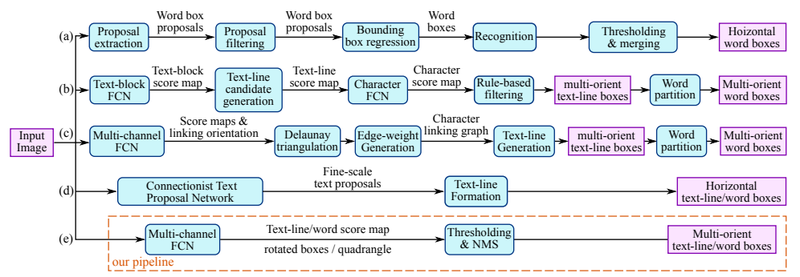

위 그림은 2017년에 발표된 [EAST: An Efficient and Accurate Scene Text Detector](https://arxiv.org/pdf/1704.03155v2.pdf)라는 논문에서 소개된 다양한 Text detection 기법을 정리한 것입니다.

2017년 당시에는 Text의 바운딩 박스를 구하는 방식이 주류를 이루었습니다. 위 그림을 보면 가로 방향(Horizontal)으로만 텍스트 박스를 구하는 방식이나 기울어지거나 세로 방향 등의 여러 방향(Multi-oriented)의 텍스트 박스를 구하는 방식이 다양하게 소개되고 있습니다. 해당 논문이 제시하는 (e)의 경우 전체 파이프라인의 길이가 짧고 간결해서 빠르면서도 정확한 Text detection 성능을 보인다고 소개하고 있습니다.

위 그림을 자세히 보면, 위에서 언급한 단어 단위의 탐지와 글자 단위의 탐지가 모두 활용되고 있습니다.

단어 단위의 탐지는 앞서 배운 Object detection의 Regression 기반의 Detection 방법입니다. Anchor를 정의하고 단어의 유무와 Bounding box의 크기를 추정해서 단어를 찾아냅니다. 글자 단위의 방식은 Bounding box regression을 사용하는 대신 글자 영역을 Segmentation하는 방법으로 접근합니다. 또한 두 가지 방법을 모두 활용한 방법이 있습니다.

아래에서는 여러 가지 접근 방식을 시간순이 아니라 대표적인 것을 예로 들어 설명해드리겠습니다.

### 1. Regression
---
-[TextBoxes: A Fast Text Detector with a Single Deep Neural Network](https://arxiv.org/pdf/1611.06779.pdf)

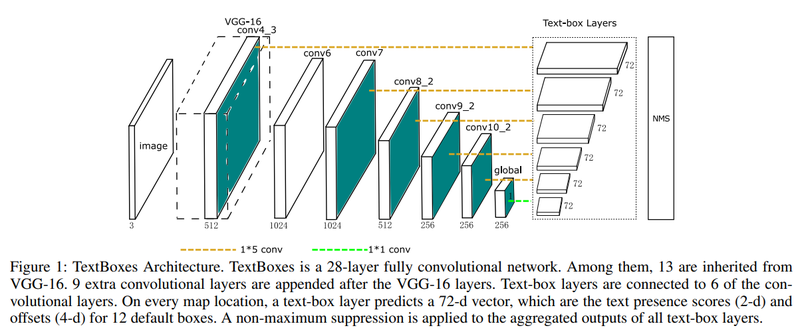

TextBoxes는 2017년 AAAI에 공개된 논문입니다. 이미지 내에서 문자를 찾아내려는 방법에는 다양한 기법들이 활용됩니다.

TextBoxes 이전에는 글자 단위로 인식한 후 결합하는 방식을 취해 왔지만 위 논문에서는 딥러닝 기반의 Detection을 이용하여 단어 단위로 인식합니다. 네트워크의 기본 구조는 [SSD: single shot multibox detector](https://arxiv.org/pdf/1512.02325.pdf)를 활용한 것을 볼 수 있습니다. 이를 통해서 빠르게 문자 영역을 탐지해 낼 수 있었다고 합니다.

일반적으로 단어들은 가로로 길기 때문에 Aspect ratio(종횡비)가 큽니다. 이에 따라 몇 가지 변형을 주게 되는데요, 기존의 SSD에서는 Regression을 위한 Convolution layer에서 3x3 크기의 kernel을 갖습니다.

하지만 여기서는 긴 단어의 Feature를 활용하기 위해서 1x5로 convolution filter를 정의하여 사용합니다. Anchor box의 aspect ratio를 1, 2, 3, 5, 7로 만들고, 이에 vertical offset을 적용하여 세로 방향으로 촘촘한 단어의 배열에 대응하도록 했습니다.

> 💠 종횡비(Aspect ratio)
종횡비는 가로와 세로 길이의 비를 의미하며, 가로세로비, 영상비, 화면비 등으로 부르기도 합니다. 일반적으로 16:9와 같이 '가로:세로'의 형태로 표현합니다. 그러나 논문에서는 가로와 세로의 비를 계산하여 하나의 숫자로 표현하고 있습니다.
>
> 💠💠 offset
일반적인 의미의 Offset이란 특정한 값에서 차이가 나는 값 또는 차이를 의미합니다. 주의할 점은 offset과 오차가 다르다는 것입니다. offset은 차이가 목적에 의해 만들어진 것과 상황에 따라 자연스럽게 발생된 것을 모두 포함하기 때문입니다.


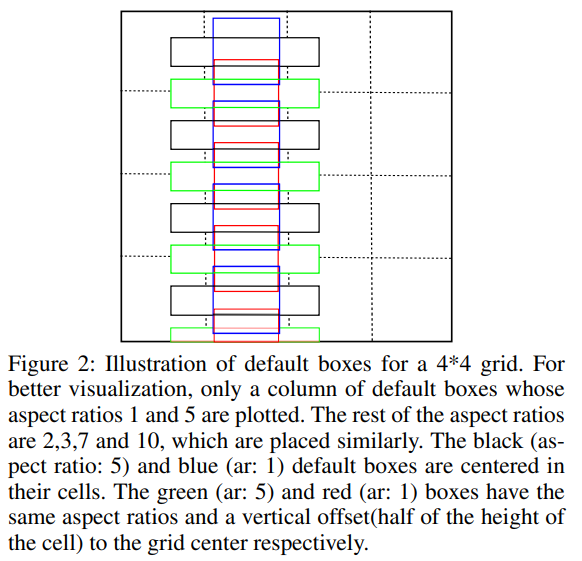

Q1. TextBoxes 논문에서는 세로로 촘촘한 단어를 인식해내기 위해서 vertical offset을 활용했다고 합니다. 위 그림을 통해 설명해주세요!

A1. Grid cell의 중앙을 기점으로 생성할 경우를 예로 든 것이 파란색(aspect ratio:1) 그리고 검은색 박스(aspect ratio:1)입니다.
그리고 이를 수직방향으로 옮겨서 촘촘하게 만들어준 것이 빨간색과 녹색입니다. 수직방향으로 Anchor box의 중앙을 하나 더 둠으로써 세로로 촘촘하게 Anchor box를 배치할 수 있게 됩니다.

### 2. Segmentation
---
- [PixelLink: Detecting Scene Text via Instance Segmentation](https://arxiv.org/pdf/1801.01315.pdf)

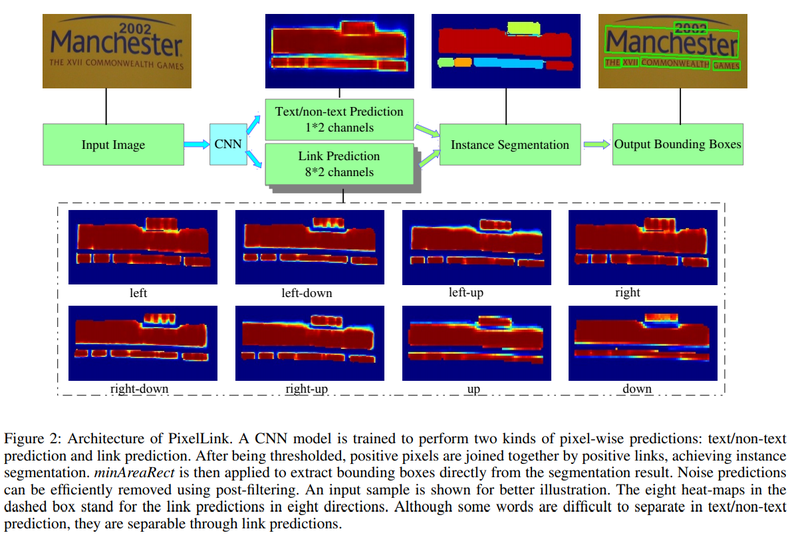

우리는 Semantic segmentation을 이미지 내의 영역을 class로 분리해내는 방법으로 배웠습니다. 이 방법을 문자의 영역을 찾기 위해서 적용하면, 배경과 글자인 영역으로 분리할 수 있습니다. 하지만 문자들은 매우 촘촘히 배열되어있으니 글자 영역으로 찾아낸 뒤에 이를 분리해내는 작업이나 연결하는 작업을 더 해서 원하는 최소단위로 만들어줘야 합니다.

PixelLink는 Text 영역을 찾아내는 segmentation과 함께, 글자가 어느 방향으로 연결되는지를 같이 학습하여 Text 영역 간의 분리 및 연결을 할 수 있는 정보를 추가적으로 활용하고 있습니다.

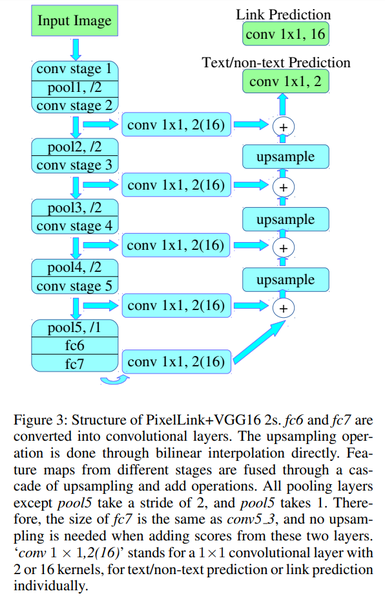

PixelLink의 전체적인 구조는 U-Net과 유사합니다. 하지만 output으로 총 9가지의 정보를 얻습니다.

위 그림의 녹색 부분이 input과 output을 의미하는데, output 중 하나는 **Text/non-text Prediction을 위한 class segmentation map** 으로 해당 영역이 Text인지 Non-text인지 예측값을 의미하는 2개의 커널을 가집니다. 나머지 8가지는 글자의 Pixel을 중심으로 인접한 8개의 Pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 **Link Prediction map**입니다.

위 그림을 보면 conv 1X1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어, 인접 pixel간 연결 구조가 지속적으로 유지되도록 하는 모델 구조임을 알 수 있습니다.

이를 통해서 인접한 pixel이 중심 pixel과 단어 단위로 연결된 pixel인지, 아니면 분리된 pixel인지 알 수 있으므로, 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해집니다.

### 3. 최근의 방법들
---
딥러닝이 빠르게 발전하는 만큼 최신 연구들은 새로운 방식들을 계속해서 시도하고 있습니다.

위에서 확인한 TextBoxes나 PixelLink는 3년 전에 공개된 논문들입니다. 그렇다면 최근에는 어떤 방식으로 문자 영역을 찾아내고 있을까요?

### 3.1. CRAFT

- [Character Region Awareness for Text Detection](https://arxiv.org/abs/1904.01941)

CRAFT는 문자(Character) 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 Segmentation 기반으로 구현한 방법입니다. 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습합니다.

문자 단위 라벨을 가진 데이터셋이 많지 않기 때문에, 단어 단위의 정보만 있는 데이터셋에 대해 단어의 영역에 Inference를 한 후, 얻어진 문자 단위의 위치를 다시 학습에 활용하는 Weakly supervised learning을 활용했습니다.

### 3.2. Pyramid Mask Text Detector

- [Pyramid Mask Text Detector](https://arxiv.org/pdf/1903.11800.pdf)

PMTD(Pyramid Mask Text Detector)는 Mask-RCNN의 구조를 활용하여 먼저 Text영역을 Region proposal network로 찾아냅니다. 그다음 Box head에서 더 정확하게 regression 및 classification을 하고 Mask head에서 Instance의 Segmentation을 하는 과정을 거칩니다.

PMTD는 Mask 정보가 부정확한 경우를 반영하기 위해서 Soft-segmentation을 활용합니다. 이전의 Mask-RCNN의 경우, 단어 영역이 Box head에 의해 빨간색으로 잡히면 위의 이미지의 baseline처럼 boundary를 모두 Text 영역으로 잡지만, PMTD는 단어의 사각형 배치 특성을 반영하여 피라미드 형태의 Score map을 활용합니다. 따라서 Pyramid 형상의 Mask를 갖게 되어 Pyramid Mask Text detector라는 이름을 붙였습니다.

# 11-4. Text recognition

### 1. Unsegmented Data
---

글자 이미지들은 문자의 순서대로 정보를 가지고 있습니다. 위의 "YOU"라는 이미지에서 "Y", "O", "U"의 영역은 이미지상에서 분리가 가능합니다.

하지만 이와 다르게 분리에 드는 비용이 많이 들거나 어려워 Segmentation이 되어있지 않은 데이터를 `Unsegmented data`라고 합니다. 이미지에서 문자를 읽어내는 OCR 분야뿐만 아니라 다른 분야들에서도 이런 데이터를 볼 수 있습니다.

예를 들어, 아래 그림과 같이 annotation이 제대로 안 된 음성데이터도 Unsegmented data의 한 종류입니다. Waveform 파일에 대한 라벨이 "the sound of"라고 달려 있다고 할 때, 해당 waveform 파일에서 어디까지가 각각 "the", "sound", "of"인지의 경계가 명확하게 분할되어 있지 않은 경우를 생각할 수 있습니다.

Unsegmented Data에는 또 어떤 것들이 있을까요? 그리고 이를 활용하기 위해서는 어떻게 해야 할까요?

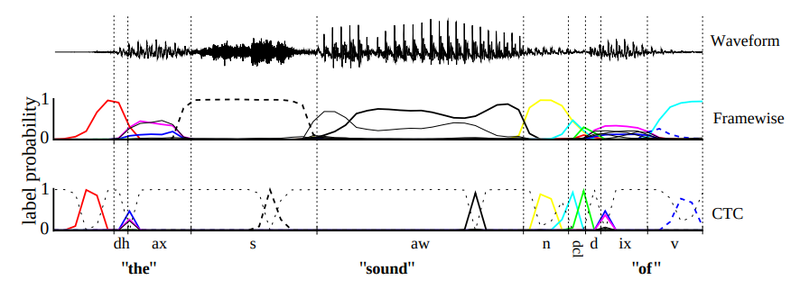

### 2. CNN과 RNN의 만남 CRNN
---
- [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)

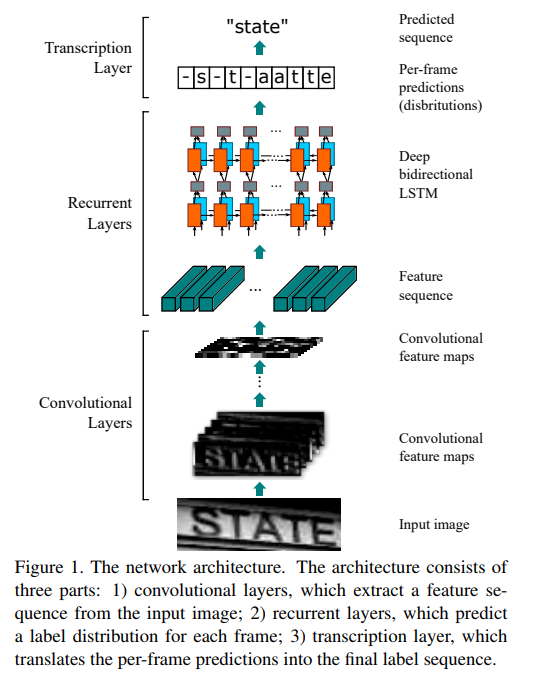

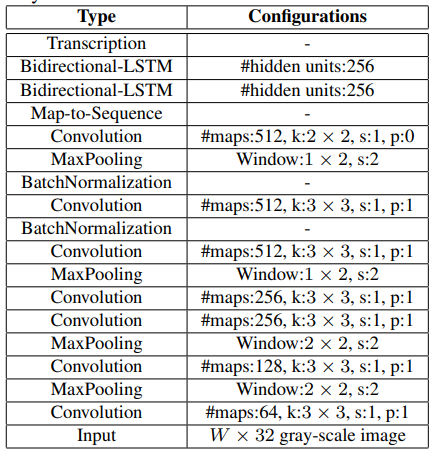

Unsegmented Data들이 가진 주요한 특징 중 하나는 segment되어 있지 않은 하위 데이터들끼리 시퀀스(sequence)를 이루고 있다는 점입니다.

그래서 연구자들이 생각해 낸 방법 중 하나는 **CNN(Convolutional neural network)과 RNN(Recurrent neural network)을 같이 쓰는 방법** 입니다. 이런 모델을 **CRNN** 이라고 합니다.

문자 이미지에서 정보를 추출하기 위해서는 Feature Extractor가 필요합니다. Feature Extractor로 사용되는 CNN 기반의 VGG 또는 ResNet과 같은 네트워크로부터 문자의 정보를 가진 Feature를 얻어낼 수 있습니다. 이렇게 추출된 Feature를 Map-To-Sequence를 통해 Sequence 형태의 feature로 변환한 후, 다양한 길이의 Input을 처리할 수 있는 RNN으로 넣습니다.

RNN이 Feature로부터 문자를 인식하기 위해서는 문자 영역처럼 넓은 정보가 필요하기 때문에, LSTM으로 구성합니다. 앞의 정보뿐만 아니라 뒤의 정보가 필요하기 때문에 이를 Bidirectional로 구성해서 Bidirectional LSTM을 사용했습니다. Bidirectional LSTM을 사용해 step마다 나오는 결과는 Transcription Layer에서 문자로 변환됩니다.

### 3. CTC
---
CRNN에서는 Step마다 Fully Connected Layer의 logit을 Softmax 함수에 넣어줌으로써 어떤 문자일 확률이 높은지 알 수 있습니다.

하지만 이 결과 그대로를 문자로 변환하면 기대한 것과 다른 결과가 나옵니다. 왜냐하면 모델의 Output은 24개의 글자로 이루어진 Sequence이지만, 실제 결과는 이와 다르기 때문이죠.

예를 들어 "HELLO"라는 이미지가 들어오면 이것의 Output이 "HHHEEELLLOOOOO..."와 같이 24자의 sequence를 보게 됩니다.

그렇다면 이 24자의 Sequence를 실제 인식 결과로 바꾸기 위해서는 어떤 방법을 써야 할까요?

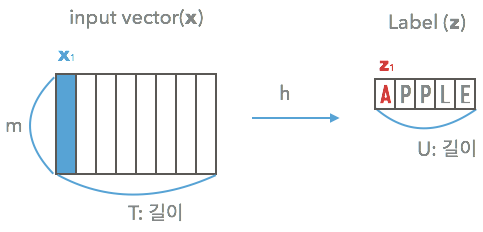

CRNN에서는 Unsegmented Data를 위해 [CTC(Connectionist Temporal Classification)](https://arxiv.org/pdf/1507.05717.pdf)를 활용합니다. CTC는 Unsegmented data와 같이 Input과 Output이 서로 다른 Length의 Sequence를 가질 때, 이를 Align 없이 활용하는 방법입니다.

논문에서 언급하는 CTC의 핵심인 모델의 Output에서 Label sequence의 확률을 구할 수 있는 방법에 대해 알아보겠습니다.

위에서 본 "HHHEEELLLOOOOO..."를 "HELLO"로 만들기 위해서는 중복되는 단어인 "HHHH..."나 "EEE...", "LLL..."들을 "H", "E", "L" 등으로 바꿔볼 수 있습니다. 그러면 "HELO"가 될 것입니다. 그렇다면 "L"이 두 번 중복되는 경우에는 어떻게 구분할 수 있을까요?

앞서 봤던 Label Encode에서 이렇게 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어줍니다.

아래 그림은 Blank token을 '-'로 대신하여 Output을 만드는 Decoder를 의미합니다. Decode 후에 중복을 제거하고, 인식할 문자가 아닌 값을 지워주면 "HELLO"라는 결과를 얻을 수 있습니다.

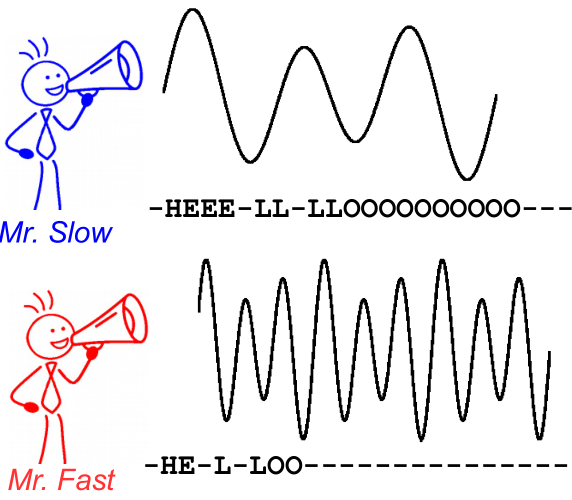

Q2. 이렇게 인식된 Text의 정확도를 판별하기 위한 단위 중 실제 정답과 예측한 단어가 얼마나 가까운지 측정할 수 있는 방법은 어떤 것이 있을까요?

A2. Edit distance라는 방법이 있습니다. 한국어로는 편집거리라고 하며 두 문자열 사이의 유사도를 판별하는 방법입니다. 예측된 단어에서 삽입, 삭제, 변경을 통해 얼마나 적은 횟수의 편집으로 정답에 도달할 수 있는지 최소 거리를 측정합니다.

### 4. TPS
---
- [Robust Scene Text Recognition With Automatic Rectification](https://arxiv.org/pdf/1603.03915.pdf)

책이 아닌 거리의 글자를 읽을 때, OCR이 어려워지는 이유는 불규칙한 방향이나 휘어진 진행 방향 때문입니다.

논문 `Robust Scene Text Recognition With Automatic Rectification` 에서는 Thin Plate Spline (TPS) Transformation을 적용하여 입력 이미지를 단어 영역에 맞게 변형 시켜 인식이 잘되도록 해줍니다.

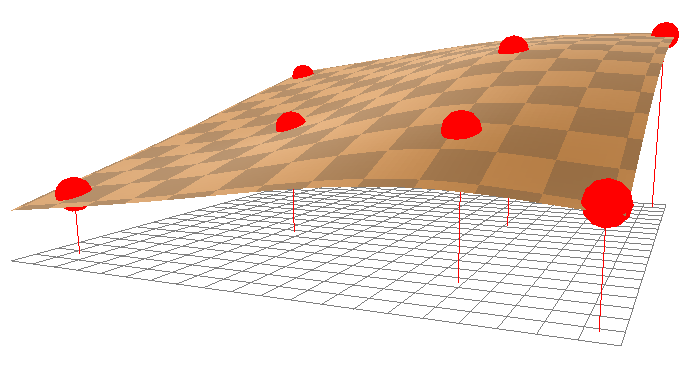

Thin plate spline은 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때, 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정해냅니다. 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있습니다.

논문에서는 Control point 20개를 미리 정의합니다. Spatial Transformer Network를 통해서 Control point가 얼마나 움직여야 하는지 예측하는 네트워크를 아래 그림과 같이 Recognition model 앞단에 붙여 입력 이미지를 정방향으로 맞춰줍니다. TPS 연산은 미분 가능한 연산이기 때문에 이 모듈을 Recognition model 앞단에 붙여서 학습이 바로 가능합니다.

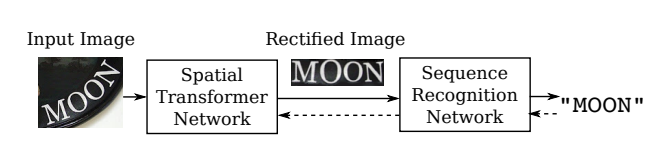

> 💠 Spatial Transformer Network란 인풋 이미지에 크기, 위치, 회전 등의 변환을 가해 추론을 더욱 용이하게 하는 transform matrix를 찾아 매핑해 주는 네트워크를 말합니다. 이해를 돕기 위해 아래 링크를 참고하세요.
>
> - [Spatial Transformation Network 란 무엇인가?](https://3months.tistory.com/197)

# 11-5. Text recognition + Attention

Attention과 Transformer가 딥러닝 분야에 큰 변화를 가져왔고, OCR 분야도 예외는 아닙니다.

### 1. Attention sequence prediction
---
- [Robust Scene Text Recognition With Automatic Rectification](https://arxiv.org/pdf/1603.03915.pdf)
- [Focusing Attention: Towards Accurate Text Recognition in Natural Images](https://arxiv.org/pdf/1709.02054.pdf)

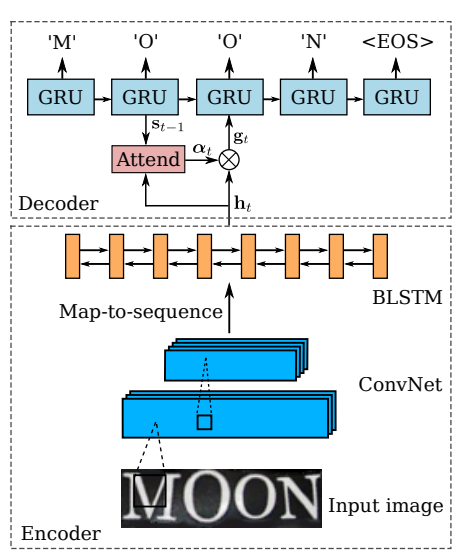

CTC를 활용한 CRNN의 경우, column에 따라서 prediction된 Label의 중복된 것들을 제거해 줌으로써 원하는 형태의 label로 만들어주었습니다.

Attention기반의 sequence prediction은 문장의 길이를 고정하고, 입력되는 Feature에 대한 Attention을 기반으로 해당 글자의 Label을 prediction합니다. RNN으로 Character label을 뽑아낸다고 생각하면 되는데, 첫 번째 글자에서 입력 feature에 대한 Attention을 기반으로 label을 추정하고, 추정된 label을 다시 입력으로 사용하여 다음 글자를 추정해내는 방식입니다.

이때 20글자를 뽑겠다고 정하게 되면 "YOU"같은 경우에는 3글자를 채우고 빈자리가 문제가 되는데요, 이러한 경우를 위해 미리 정해둔 Token을 사용합니다. 이 Token에는 처음에 사용되는 "start" token과 끝에 사용되는 "end" token이 있습니다. 필요에 따라서 예외처리나 공백을 위한 token을 만들어서 사용하기도 합니다.

- [What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis](https://arxiv.org/pdf/1904.01906.pdf)

Attention 기반의 Recognition이 더욱 좋은 성능을 보이고 있는 것을 위 링크에 소개한 네이버 Clova의 논문 'What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis'에서 확인할 수 있습니다. 이 논문에서는 CTC와 attention만이 아니라 TPS 등 Recognition에서 쓰이는 다양한 모듈들을 비교 평가를 하고 있습니다.

https://youtu.be/NQeaLc2X8vk

위 영상은 네이버 Clova에서 CRAFT와 "What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis"에 대해서 설명해 주는 영상이니 참고하시면 좋습니다.


### 2. Transformer와 함께!
---
- [A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition](https://arxiv.org/pdf/1904.01375v1.pdf)
- [hulk89님의 논문리뷰](https://hulk89.github.io/machine%20learning/2019/05/15/A-Simple-and-Robust-Convolutional-Attention-Network-For-Irregular-Text-Recognition/)

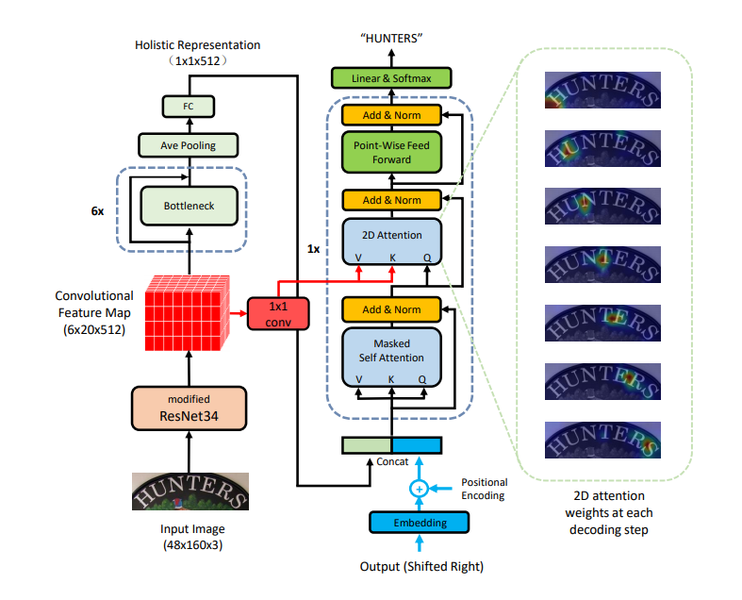

Transformer도 Recognition 모델에 활용되기 시작합니다. 다양한 논문에서 시도되고 있지만 "A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition"가 대표적인 논문입니다.

위 논문에서는 Irregular text를 잘 인식하기 위해서 2d space에 대한 attention을 활용하여 문자를 인식하기 위해 Transformer를 활용합니다.

Transformer는 Query, Key, Value라는 개념을 통해서 Self-Attention을 입력으로부터 만들어냅니다. 이를 통해서 입력에서 중요한 Feature에 대해 Weight를 주게 되죠. Attention의 핵심은 Decoder의 현재 포지션에서 중요한 Encoder의 State에 가중치가 높게 매겨진다는 점입니다.

위에서 Attention이 시각화된 이미지를 눈으로 볼 수 있는데요, Decoder의 각 Step에 따라 입력에 대한 Visual Attention이 시각화된 모습입니다.